In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import pandas as pd
from os.path import abspath

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv(abspath('../../../data/MSFT/MSFT-5-Year.csv'), index_col=0, parse_dates=['Date'])

df.columns.name = df.index.name
df.index.name = None

df = df.filter(['Date', 'Open'])
print(df.shape)
df.head()

(1245, 1)


Date,Open
2017-03-01,64.129997
2017-03-02,64.690002
2017-03-03,63.990002
2017-03-06,63.970001
2017-03-07,64.190002


In [4]:
# Split the df into a training set and a test set
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_set, test_set = train_test_split(df, test_size=0.25, shuffle=False)

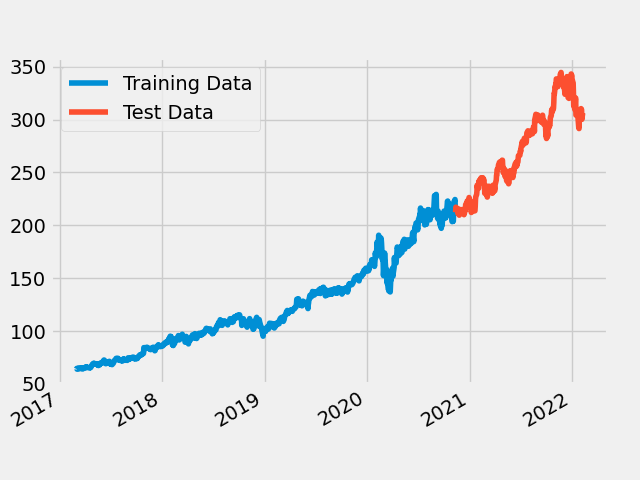

In [5]:
# Plot the training and testing data
train_set.Open.plot(label='Training Data')
test_set.Open.plot(label='Test Data')
plt.legend()

In [6]:
from sklearn.preprocessing import MinMaxScaler

transformer = MinMaxScaler()
train_scaled = transformer.fit_transform(train_set)

In [7]:
import numpy as np

x_train = []
y_train = []

for i in range(60,len(train_scaled)):
    x_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)

(873, 60)


In [8]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)

(873, 60, 1)


In [9]:
print(test_set.shape)

(312, 1)


In [10]:
import tensorflow as tf

#List attached GPU devices
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

model = Sequential()
model.add(LSTM(units=100, activation='relu', return_sequences=True, input_shape=(x_train.shape[1],1))) 
model.add(LSTM(units=50, activation='relu', return_sequences=True))
model.add(LSTM(units=10, activation='relu'))
model.add(Dense(units=1))

model.summary()

Metal device set to: AMD Radeon Pro 560

systemMemory: 16.00 GB
maxCacheSize: 2.00 GB



2022-02-26 00:14:22.914273: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-26 00:14:22.915036: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-26 00:14:22.915617: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            30200     
                                                                 
 lstm_2 (LSTM)               (None, 10)                2440      
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 73,451
Trainable params: 73,451
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Create an EarlyStopping callback
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [13]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=10, batch_size=32, callbacks=[early_stopping], validation_split=0.1)

Epoch 1/10


2022-02-26 00:14:34.765566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/25 [>.............................] - ETA: 22:53 - loss: 0.1201

In [ ]:
model.save('/Users/aditya/Programming/stock-market-predictions/stock_market_predictions/forecasting/LSTM/MSFT-5-Year-LSTM.h5')

In [ ]:
# from keras.models import load_model

# model = load_model('/Users/aditya/Programming/stock-market-predictions/stock_market_predictions/forecasting/LSTM/MSFT-5-Year-LSTM.h5')

In [ ]:
print(df.shape)

inputs = df[len(df)-len(test_set)-60 : ].values
print(inputs.shape)
inputs = inputs.reshape(-1,1)
print(inputs.shape)
inputs = transformer.transform(inputs)
print(inputs.shape)

In [ ]:
x_test = []
for i in range(60,len(inputs)):
    x_test.append(inputs[i-60:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape)

In [ ]:
predicted = model.predict(x_test)
print(predicted.shape)
# predicted = np.reshape(predicted, (predicted.shape[0], 1))
# predicted = transformer.inverse_transform(predicted)

In [ ]:
# predicted = np.reshape(predicted, (predicted.shape[0], 1))
predicted = transformer.inverse_transform(predicted)

In [ ]:
print(predicted.shape)

# Convert the predicted values to a dataframe
predicted_df = pd.DataFrame(predicted)

# Rename the column to "Open"
predicted_df.columns = ['Open']

# Add a new column called "Date" that has the same index as the other dataframe
predicted_df['Date'] = df[len(df)-len(test_set)-0 : ].index

# Set the 'Date' column as the index
predicted_df = predicted_df.set_index('Date')

predicted_df.head()

In [ ]:
# Plot the predicted values
predicted_df.plot(label='Predicted')


In [ ]:
def plot_predictions(test, predicted):
    plt.figure(4, figsize=(10,6))
    plt.plot(test, color="red", label="real MSFT stock price")
    plt.plot(predicted, color="blue", label="predicted stock price")
    plt.title("MSFT stock price prediction")
    plt.xlabel("time")
    plt.ylabel("MSFT stock price")
    plt.legend()
    plt.show()

In [ ]:
import math
from sklearn.metrics import mean_squared_error

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("the root mean squared error is : {}.".format(rmse))

In [ ]:
plot_predictions(test_set, predicted_df)

In [ ]:
return_rmse(test_set, predicted)